# Verify the weight of P-LYR+P-LYR

## Prepare environment and  define parameters 

In [19]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !pip install qfnn


import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools


import pylatexenc

sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.n_lyr_circ import N_LYR_Circ
from src.qfnn.qf_circ.u_lyr_circ import U_LYR_Circ
from src.qfnn.qf_circ.p_lyr_circ import P_LYR_Circ,P_Neuron_Circ
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix

print = functools.partial(print, flush=True)






## Load data

## Inference

In [20]:
import math
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
weight_1 = torch.tensor([[1.,  -1.,  1.,  1.],[-1., 1., 1., -1.]])
weight_2 = torch.tensor([[1.,  -1.],[-1.,  -1.]])
angle = [math.pi/2,math.pi/3,math.pi/2,math.pi/3]
norm_flag = [True,False]
norm_para = torch.tensor([0.3060,0.6940])



QuantumRegister(4, 'p00_qbit')
QuantumRegister(4, 'p10_qbit')
Layer 1 built!


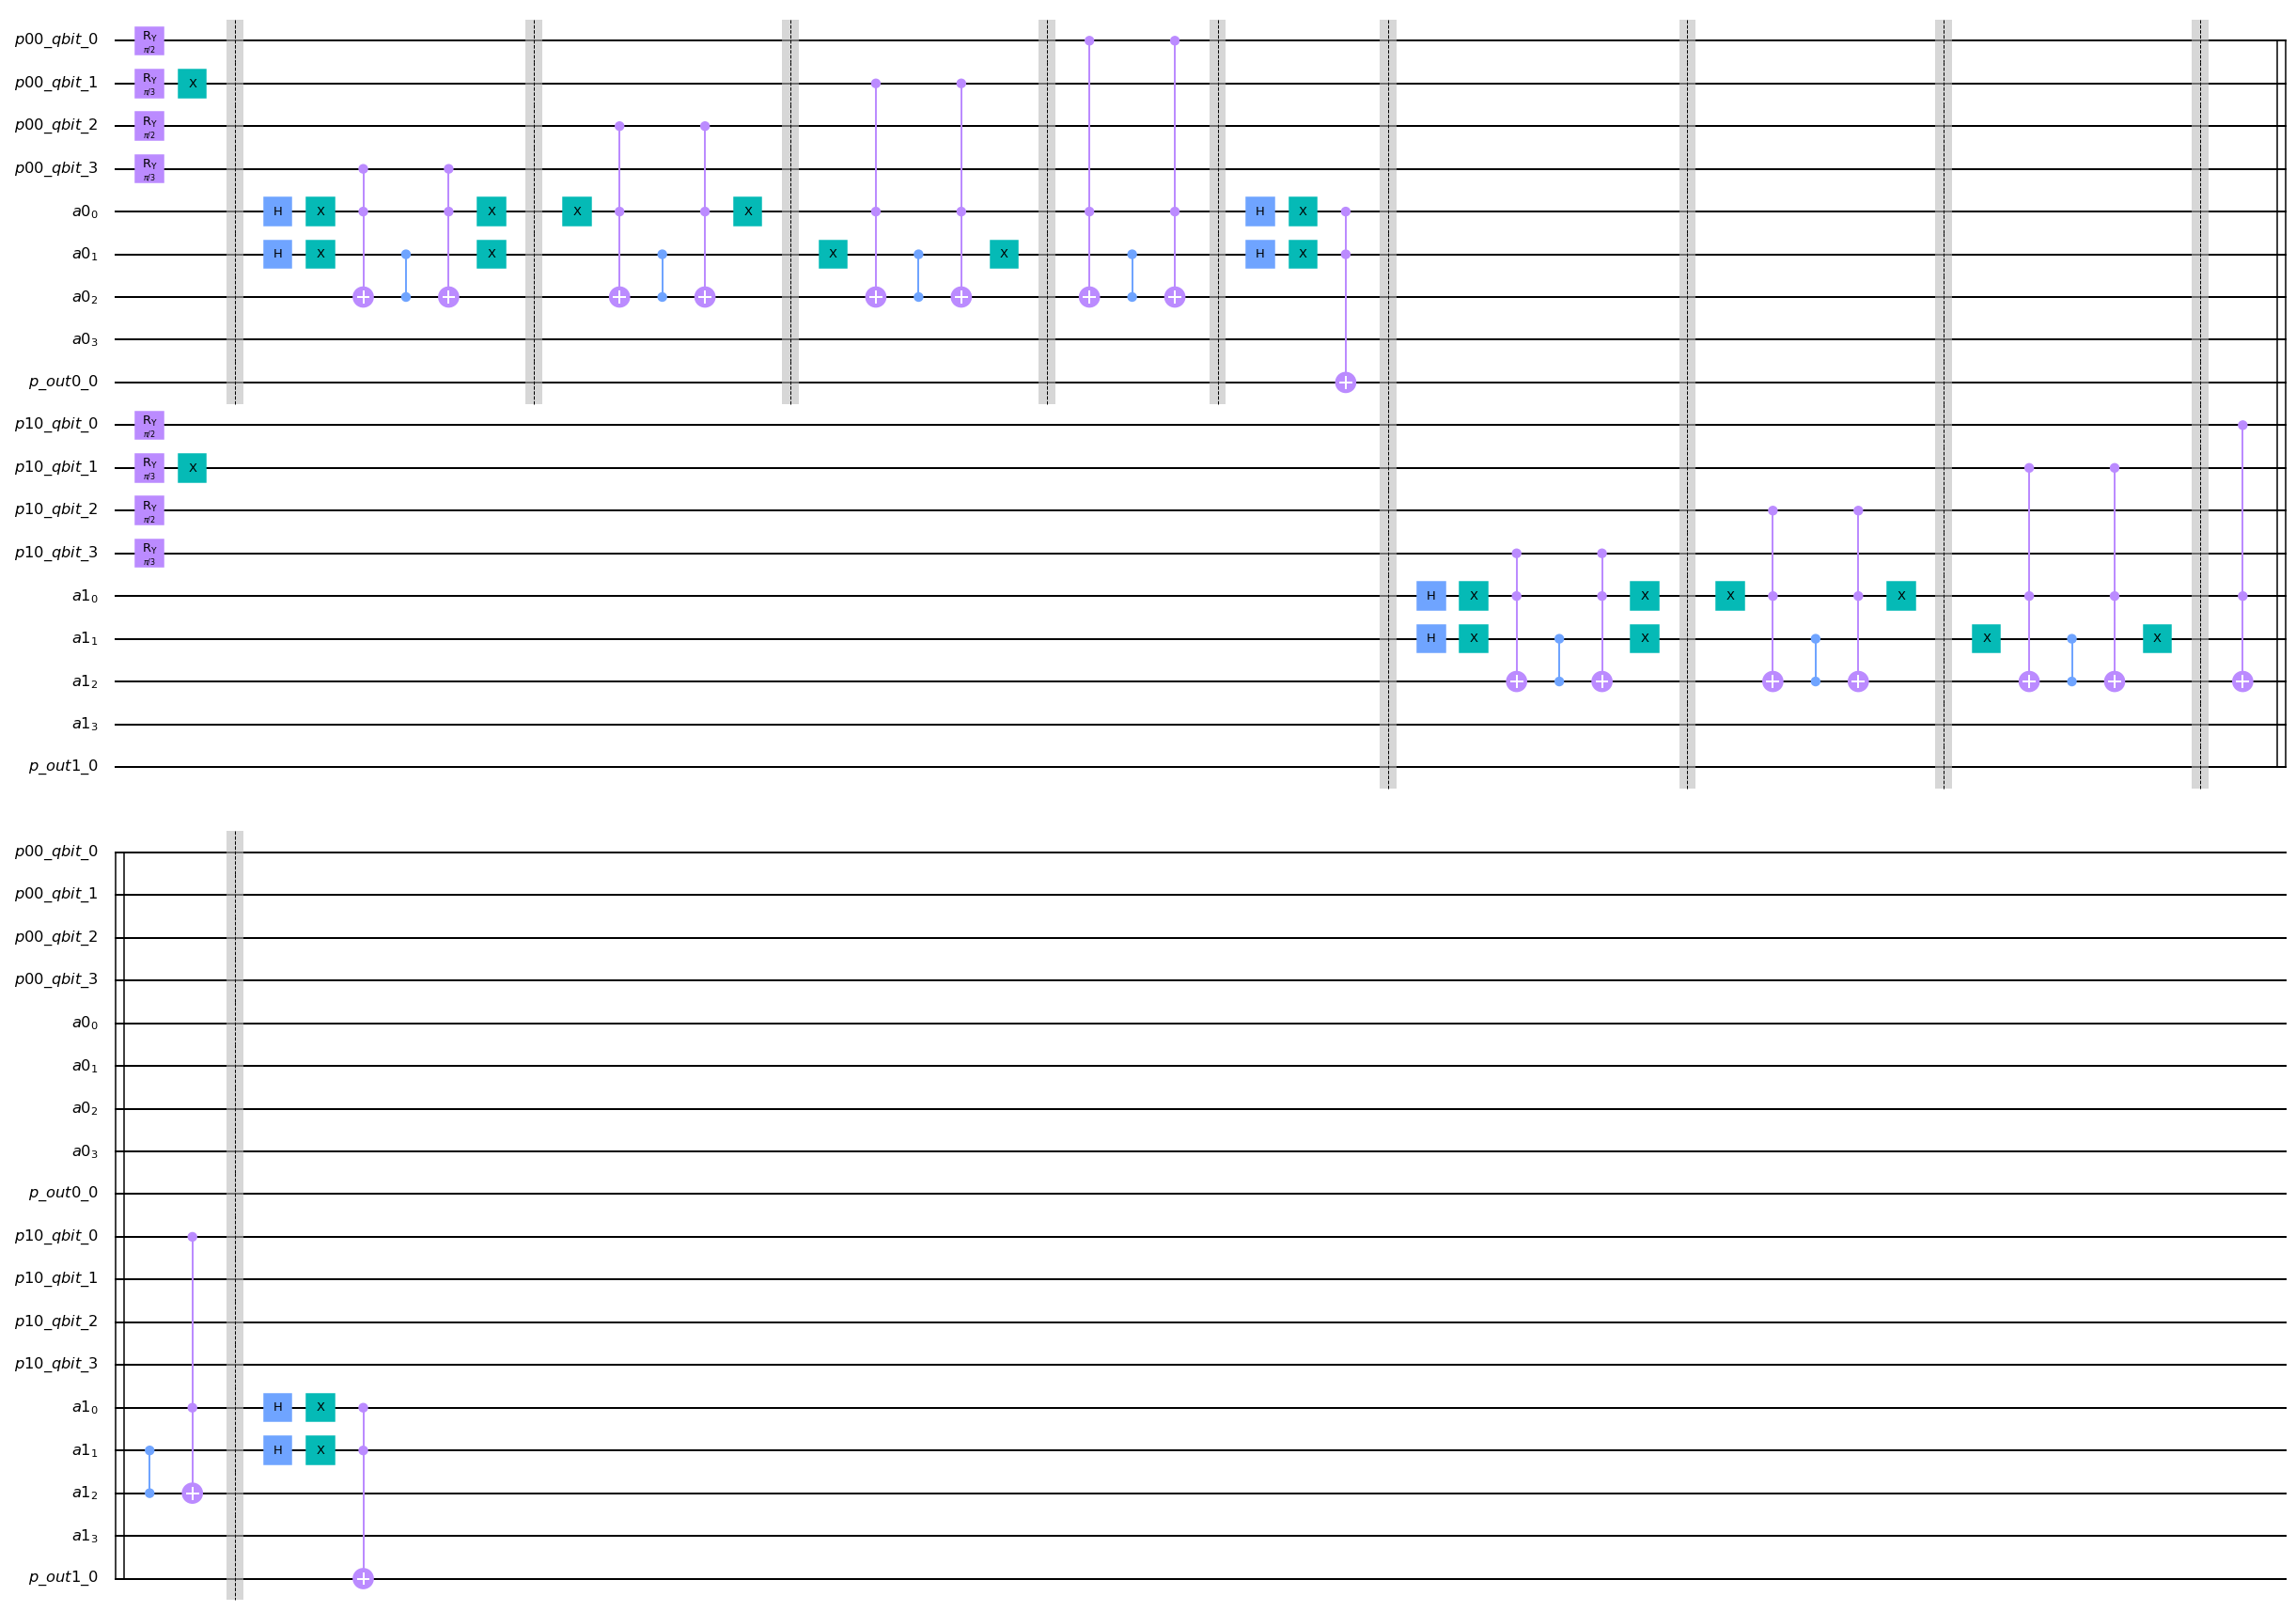

In [26]:
################ Weiwen on 12-30-2020 ################
# Generate the circuit of u-layer
######################################################
#define your input and output number
input_list = []
aux_list = []
output_list = []
circuit = QuantumCircuit()
for i in range(2):
    p_layer = P_Neuron_Circ(4) 
    #init circuit
    #add input qubit to your circuit
    inps = p_layer.add_input_qubits(circuit,'p'+str(i))
    input_list.append(inps)
    #add auxiliary qubit to your circuit
    aux =p_layer.add_aux(circuit,'a'+str(i))
    aux_list.append(aux)
    #add output qubit to your circuit
    output = p_layer.add_out_qubits(circuit,'p_out'+str(i))
    output_list.append(output)
    #add ulayer to your circuit
    p_layer.forward(circuit,[weight_1[0]],input_list[i][0],output_list[i],angle,aux_list[i])
    

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circuit.draw(layout,fold=fold)
# print(circuit)
print("Layer 1 built!")


Output layer created!
Layer 2 built!


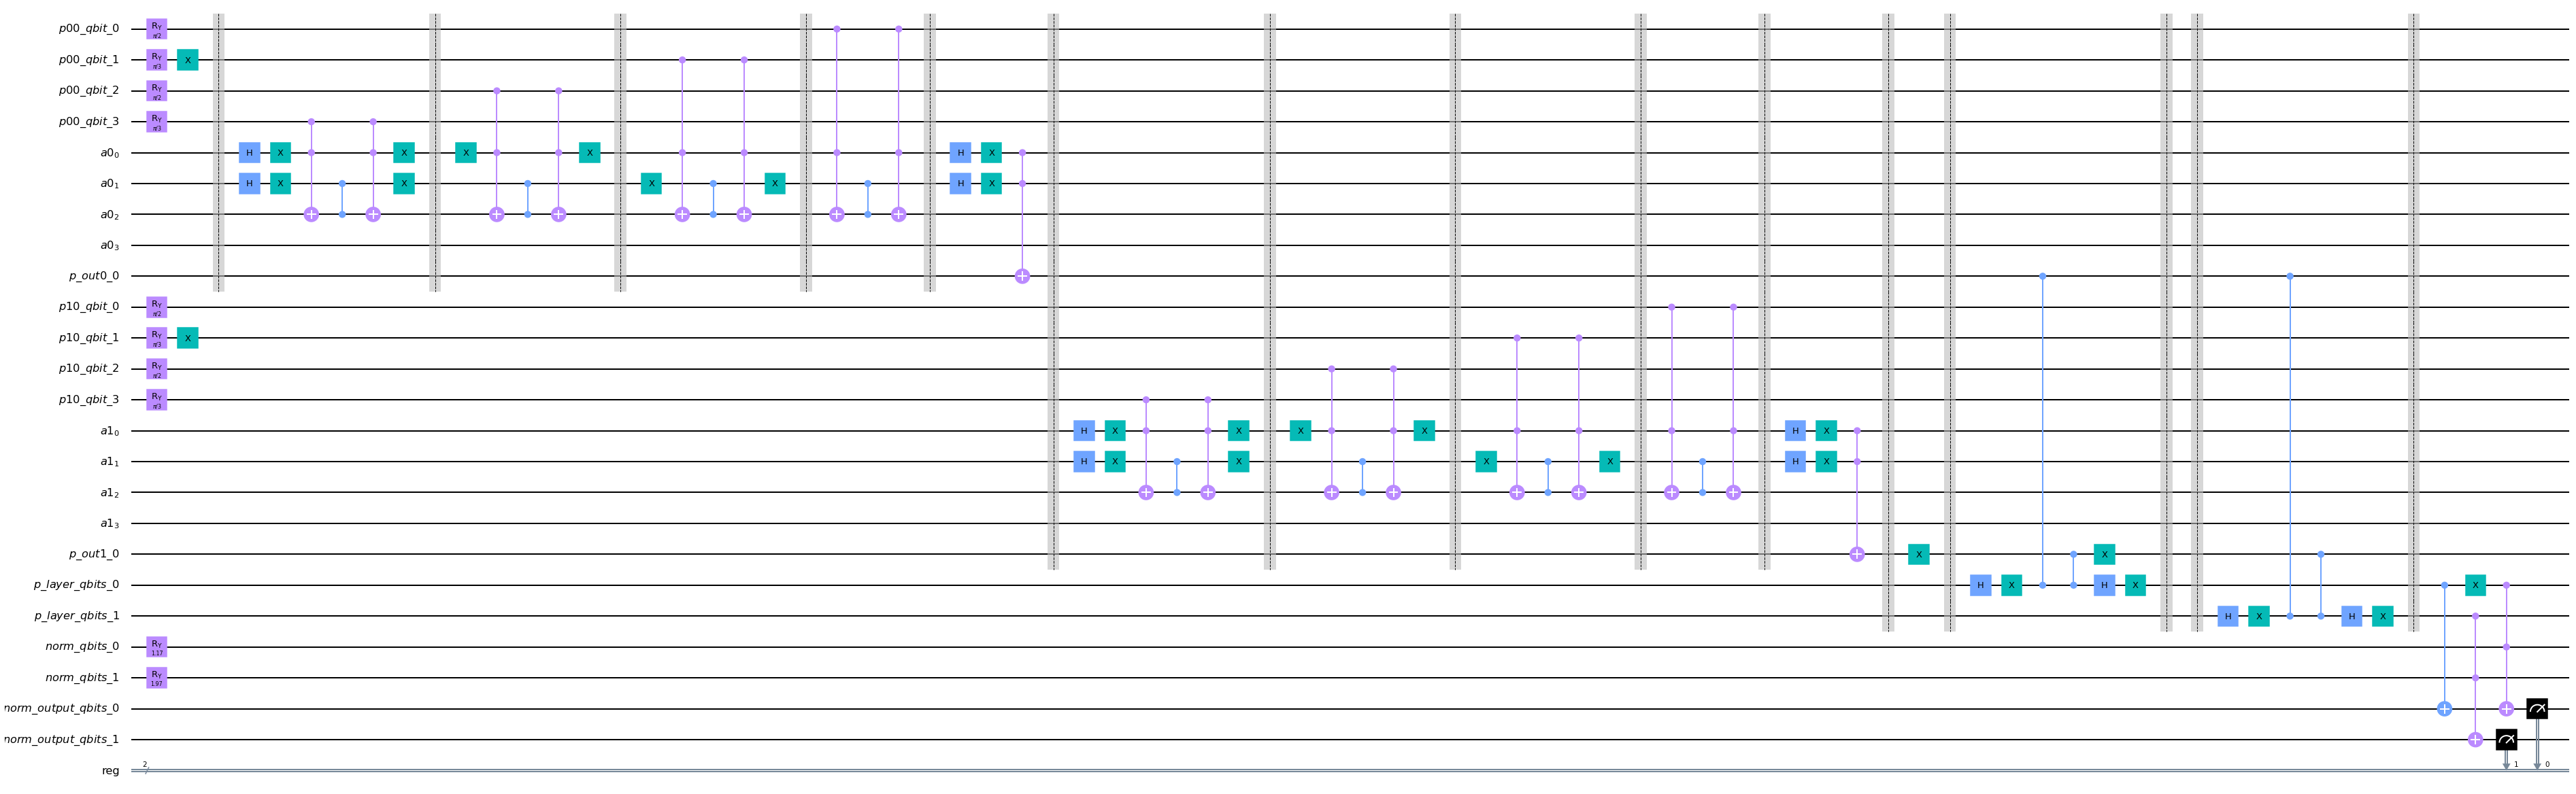

In [22]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################

p_layer = P_LYR_Circ(2,2)
p_layer_output = p_layer.add_out_qubits(circuit)
circuit.barrier()

p_layer.forward(circuit,weight_2,output_list,p_layer_output)


norm = N_LYR_Circ(2)
norm_qubit = norm.add_norm_qubits(circuit)
norm_output_qubit = norm.add_out_qubits(circuit)
norm.forward(circuit,p_layer_output,norm_qubit,norm_output_qubit,norm_flag,norm_para)


add_measure(circuit,norm_output_qubit,'reg')

print("Output layer created!")

# print(circuit)
circuit.draw('mpl',fold =300)
print("Layer 2 built!")